In [1]:
import os
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import scipy.signal as sg
from sklearn.decomposition import SparsePCA
from scipy import stats
import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from datetime import datetime
import pytz
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt

import itertools

In [19]:
fog_results = pd.read_csv('~/Documents/fog_project_datasets/streamlit_dataset.csv')
asos = pd.read_csv('~/Documents/fog_project_datasets/asos_oregon.csv')
fog_results['time_pst'] = pd.to_datetime(fog_results['time_pst'])
fog_results['date'] = pd.to_datetime(fog_results['date']).dt.date



In [52]:
asos.columns

Index(['station', 'valid', 'lon', 'lat', 'elevation', 'tmpf', 'dwpf', 'relh',
       'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby', 'gust', 'skyc1',
       'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4',
       'wxcodes', 'ice_accretion_1hr', 'ice_accretion_3hr',
       'ice_accretion_6hr', 'peak_wind_gust', 'peak_wind_drct',
       'peak_wind_time', 'feel', 'metar', 'snowdepth'],
      dtype='object')

In [54]:
asos['skyl2'].value_counts()

skyl2
5000.0     1609
1400.0     1450
3000.0     1417
2900.0     1411
2700.0     1405
2800.0     1404
3500.0     1399
6000.0     1391
2500.0     1374
2600.0     1350
3300.0     1343
1300.0     1317
3400.0     1304
2400.0     1300
1200.0     1263
2100.0     1260
2000.0     1258
2200.0     1255
2300.0     1255
3200.0     1205
1500.0     1186
1600.0     1151
1800.0     1147
1900.0     1143
3600.0     1114
5500.0     1105
3100.0     1094
3700.0     1037
1100.0     1008
1700.0      980
3800.0      947
1000.0      911
7000.0      907
3900.0      855
4100.0      853
4000.0      810
4200.0      738
4300.0      721
4800.0      707
6500.0      682
900.0       679
4400.0      622
4500.0      582
4700.0      565
4600.0      560
8000.0      545
4900.0      538
800.0       528
9000.0      528
7500.0      505
11000.0     450
10000.0     402
700.0       401
12000.0     347
8500.0      299
9500.0      172
600.0       169
500.0        28
Name: count, dtype: int64

In [71]:
summary_df = fog_results.groupby(['site', 'year'])['rf_pred'].mean().reset_index().merge(
    fog_results.groupby(['site', 'year'])['date'].agg(['min', 'max']), on = ['site', 'year']
)
summary_df['rf_pred'] = (summary_df['rf_pred'] * 100).astype(int).astype(str) + '%'
summary_df.rename(columns={'rf_pred': '% Daytime Fog','min': 'Start', 'max': 'End'}, inplace=True)
summary_df['Start'] = pd.to_datetime(summary_df['Start']).dt.strftime('%b %d')
summary_df['End'] = pd.to_datetime(summary_df['End']).dt.strftime('%b %d')

# Now format the DataFrame as required, for example:
# summary_df['Photo Collection Start Date'] = summary_df['Photo Collection Start Date'].dt.strftime('%Y-%m-%d')
# summary_df['Photo Collection End Date'] = summary_df['Photo Collection End Date'].dt.strftime('%Y-%m-%d')
summary_df

,site,year,rf_pred,Start,End
0,Agate Beach,2022,22%,Jul 04,Sep 30
1,Agate Beach,2023,7%,May 01,Sep 30
2,Beverly,2022,18%,Jul 04,Aug 28
3,Cannon Beach,2022,12%,Jul 09,Sep 30
4,Cannon Beach,2023,3%,May 01,Sep 30
5,Lincoln City,2022,20%,Jul 04,Sep 30
6,Lincoln City,2023,13%,May 01,Sep 30
7,Otter Rock,2022,11%,Jul 04,Sep 30
8,Otter Rock,2023,7%,May 01,Sep 30
9,Pacific City,2022,12%,Jul 04,Sep 30


In [45]:
model_col_names = {'Random Forest': 'rf_pred', 'Logistic Regression': 'logit_pred', 'Convolutional Neural Network': 'cnn_pred'}
selected_col_name = model_col_names[selected_model]
fog_results['model_show'] = fog_results[selected_col_name]


In [46]:
fog_results

,photo,Label,site,Label_train,rf_pred,logit_pred,cnn_pred,year,month,day,...,station,lon_y,lat_y,elevation,tmpf,relh,drct,sknt,vsby,model_show
0,2022_07-04.0900_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,...,ONP,-124.0579,44.5804,48.0,57.2,82.120,0.0,0.0,10.000,0
1,2022_07-04.0930_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,...,ONP,-124.0579,44.5804,48.0,54.5,90.625,0.0,0.0,10.000,0
2,2022_07-04.1000_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,0,2022,7,4,...,ONP,-124.0579,44.5804,48.0,59.0,76.980,30.0,3.0,10.000,0
3,2022_07-04.1030_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,...,ONP,-124.0579,44.5804,48.0,59.0,76.980,45.0,4.0,10.000,0
4,2022_07-04.1100_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,0,2022,7,4,...,ONP,-124.0579,44.5804,48.0,59.0,76.980,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29867,2023_09-30.1900_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,...,TMK,-123.8144,45.4182,11.0,59.0,100.000,290.0,8.0,3.000,0
29868,2023_09-30.2000_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,...,TMK,-123.8144,45.4182,11.0,57.2,100.000,270.0,7.0,0.500,0
29869,2023_09-30.2030_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,...,TMK,-123.8144,45.4182,11.0,57.2,100.000,0.0,2.0,1.625,0
29870,2023_09-30.2100_pacificcityor.jpg,not_foggy,Pacific City,0.0,0,0,0,2023,9,30,...,TMK,-123.8144,45.4182,11.0,53.6,100.000,NaN,4.0,0.750,0


In [42]:
['_'.join(col) for col in summary_df.columns]

TypeError: sequence item 1: expected str instance, int found

In [24]:
asos_loc = asos[['station', 'lon', 'lat']].drop_duplicates()
asos_loc.columns = ['Site Name', 'lon', 'lat']
asos_loc['Site Name'] = 'ASOS Station ' + asos_loc['Site Name'] 
surfline_loc = fog_results[['site','lon_x','lat_x',]].drop_duplicates()
surfline_loc.columns = ['Site Name', 'lon', 'lat']
surfline_loc['Site Name'] = 'Surfline Camera at ' + surfline_loc['Site Name'] 
plot_data = pd.concat([asos_loc, surfline_loc])

In [33]:
colors1 = sns.color_palette('winter', len(asos_loc)).as_hex()  # Using seaborn color palette
colors1

['#0024ed', '#0049db', '#006dc8', '#0092b6', '#00b6a4', '#00db92']

In [32]:
colors2 = sns.color_palette('autumn', len(surfline_loc)).as_hex()  # Using seaborn color palette
colors2

['#ff2400', '#ff4900', '#ff6d00', '#ff9200', '#ffb600', '#ffdb00']

In [13]:
fog_results.columns

Index(['photo', 'Label', 'site', 'Label_train', 'rf_pred', 'logit_pred',
       'cnn_pred', 'year', 'month', 'day', 'hour', 'minute', 'time_pst',
       'time_delta', 'td_count', 'date', 'rf_pred_staggered_site',
       'logit_pred_staggered_site', 'cnn_pred_staggered_site', 'lat_x',
       'lon_x', 'station', 'lon_y', 'lat_y', 'elevation', 'tmpf', 'relh',
       'drct', 'sknt', 'vsby'],
      dtype='object')

In [14]:
model_plot_scale_min = 1.05
model_plot_scale_max = 1.1
point_space = np.linspace(model_plot_scale_min, model_plot_scale_max, 4)
model_options = ['Random Forest', 'Logistic Regression', 'Convolutional Neural Network', 'Manual Labels']
model_col_names = ['rf_pred', 'logit_pred', 'cnn_pred', 'Label_train']
model_stagger = {key: value for key, value in zip(model_col_names, point_space)}

for col in model_col_names:
    new_col_name = col + '_stagger'
    fog_results[new_col_name] = fog_results[col].map({0: np.nan, 1: model_stagger[col]})


In [16]:
fog_results.describe()

,Label_train,rf_pred,logit_pred,cnn_pred,year,month,day,hour,minute,td_count,...,elevation,tmpf,relh,drct,sknt,vsby,rf_pred_stagger,logit_pred_stagger,cnn_pred_stagger,Label_train_stagger
count,7108.000000,29872.000000,29872.000000,29872.000000,29872.000000,29872.000000,29872.000000,29872.000000,29872.000000,29686.000000,...,26935.000000,26867.000000,26866.000000,25718.000000,25952.000000,26568.000000,3276.00,3244.000000,3187.000000,827.0
mean,0.116348,0.109668,0.108597,0.106689,2022.596713,7.348587,15.754653,12.981655,15.009039,26561.343327,...,34.941749,59.589673,78.625320,241.407963,7.455285,8.752832,1.05,1.066667,1.083333,1.1
std,0.320664,0.312481,0.311138,0.308722,0.490566,1.290322,8.653722,3.742525,15.000248,6263.163063,...,18.249408,13.134968,13.369696,116.604550,4.711698,2.437759,0.00,0.000000,0.000000,0.0
min,0.000000,0.000000,0.000000,0.000000,2022.000000,5.000000,1.000000,7.000000,0.000000,1.000000,...,7.000000,-34.600000,11.940000,0.000000,0.000000,0.250000,1.05,1.066667,1.083333,1.1
25%,0.000000,0.000000,0.000000,0.000000,2022.000000,7.000000,8.000000,10.000000,0.000000,28066.000000,...,11.000000,56.316667,71.640000,200.000000,4.000000,8.500000,1.05,1.066667,1.083333,1.1
50%,0.000000,0.000000,0.000000,0.000000,2023.000000,7.000000,16.000000,13.000000,30.000000,28066.000000,...,48.000000,60.800000,77.970000,295.000000,7.000000,10.000000,1.05,1.066667,1.083333,1.1
75%,0.000000,0.000000,0.000000,0.000000,2023.000000,8.000000,23.000000,16.000000,30.000000,28066.000000,...,48.000000,64.400000,87.830000,330.000000,11.000000,10.000000,1.05,1.066667,1.083333,1.1
max,1.000000,1.000000,1.000000,1.000000,2023.000000,9.000000,31.000000,19.000000,30.000000,28066.000000,...,48.000000,95.900000,100.000000,360.000000,29.000000,10.000000,1.05,1.066667,1.083333,1.1


[Text(0, 0.5, '')]

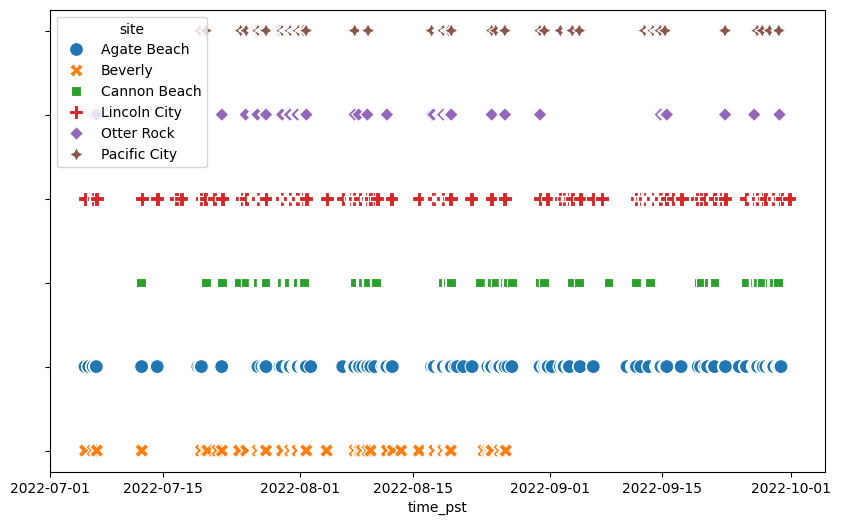

In [3]:
from matplotlib.dates import DateFormatter, HourLocator,DayLocator
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(10,6))

sp = sns.scatterplot(data = fog_results.loc[(fog_results['year']==2022)
                                            # &(fog_results['month']==7)
                                   # &(fog_results['day']==12)
                                      ],
            x = 'time_pst', hue = 'site', style = 'site', y = 'rf_pred_staggered_site', s = 100)

# Make the y-axis tick labels blank
sp.set(yticklabels=[])

# You can also remove the y-axis label if desired using the method below
sp.set(ylabel=None)

# sp.xaxis.set_major_locator(MaxNLocator(nbins=9)) # Ticks every 6 hours
# sp.xaxis.set_major_formatter(DateFormatter('%D'))
# plt.setp(sp.get_xticklabels(), rotation=45, ha='right') # Set the rotation for the tick labels



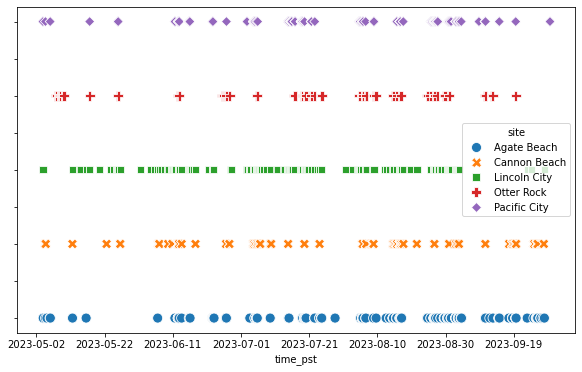

In [115]:
from matplotlib.dates import DateFormatter, HourLocator,DayLocator
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(10,6))

sp = sns.scatterplot(data = fog_results.loc[(fog_results['year']==2023)
                                            # &(fog_results['month']==7)
                                   # &(fog_results['day']==12)
                                      ],
            x = 'time_pst', hue = 'site', style = 'site', y = 'rf_pred_staggered_site', s = 100)

# Make the y-axis tick labels blank
sp.set(yticklabels=[])

# You can also remove the y-axis label if desired using the method below
sp.set(ylabel=None)

sp.xaxis.set_major_locator(MaxNLocator(nbins=9)) # Ticks every 6 hours
# sp.xaxis.set_major_formatter(DateFormatter('%D'))
# plt.setp(sp.get_xticklabels(), rotation=45, ha='right') # Set the rotation for the tick labels



In [6]:
fog_results.site.unique()

array(['Agate Beach', 'Beverly', 'Cannon Beach', 'Lincoln City',
       'Otter Rock', 'Pacific City'], dtype=object)

In [ ]:
fog_results

In [50]:
fog_results

,photo,Label,site,Label_train,rf_pred,logit_pred,cnn_pred,year,month,day,hour,minute,time_pst,time_delta,td_count,rf_pred_staggered_site
0,2022_07-04.0900_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,7,0,2022-07-04 07:00:00-07:00,NaN,NaN,NaN
1,2022_07-04.0930_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,7,30,2022-07-04 07:30:00-07:00,0 days 00:30:00,28066.0,NaN
2,2022_07-04.1000_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,0,2022,7,4,8,0,2022-07-04 08:00:00-07:00,0 days 00:30:00,28066.0,NaN
3,2022_07-04.1030_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,0,2022,7,4,8,30,2022-07-04 08:30:00-07:00,0 days 00:30:00,28066.0,NaN
4,2022_07-04.1100_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,0,2022,7,4,9,0,2022-07-04 09:00:00-07:00,0 days 00:30:00,28066.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29867,2023_09-30.1900_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,17,0,2023-09-30 17:00:00-07:00,0 days 00:30:00,28066.0,NaN
29868,2023_09-30.2000_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,18,0,2023-09-30 18:00:00-07:00,0 days 01:00:00,582.0,NaN
29869,2023_09-30.2030_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,0,2023,9,30,18,30,2023-09-30 18:30:00-07:00,0 days 00:30:00,28066.0,NaN
29870,2023_09-30.2100_pacificcityor.jpg,not_foggy,Pacific City,0.0,0,0,0,2023,9,30,19,0,2023-09-30 19:00:00-07:00,0 days 00:30:00,28066.0,NaN


/opt/anaconda3/envs/stenv/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/stenv/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/stenv/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/stenv/lib/python3.9/

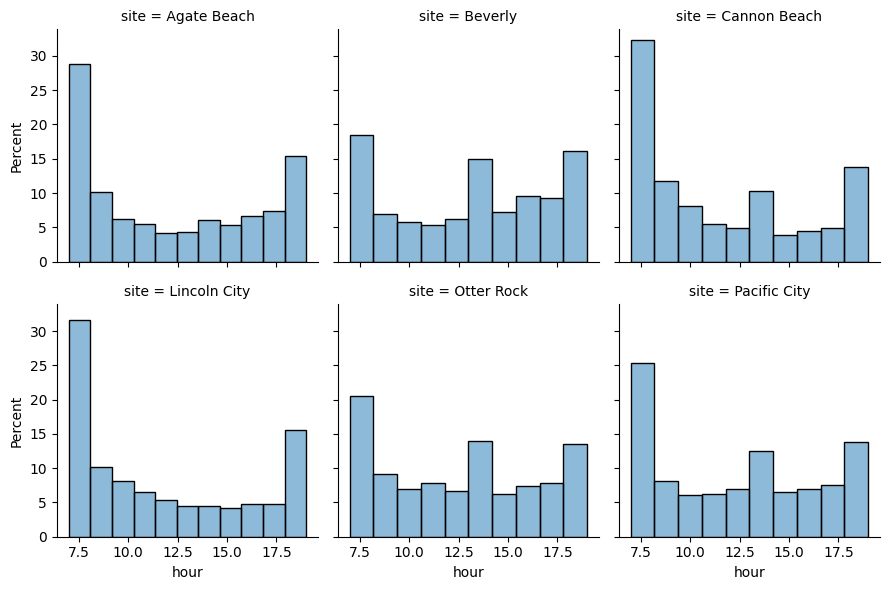

In [17]:
##most frequent fog hours per day
# sns.histplot(data = fog_results.loc[fog_results['rf_pred']==1]
#             ,x = 'hour',  hue = 'site')
g = sns.FacetGrid(data=fog_results.loc[fog_results['rf_pred'] == 1]
              ,col='site', col_wrap=3, sharey=True)
g.map_dataframe(sns.histplot, x = 'hour', hue = 'site',stat="percent")
# sns.histplot(data=fog_results.loc[fog_results['rf_pred'] == 1]
#              , x='hour', hue='site', col='site', multiple='stack', col_wrap=3)

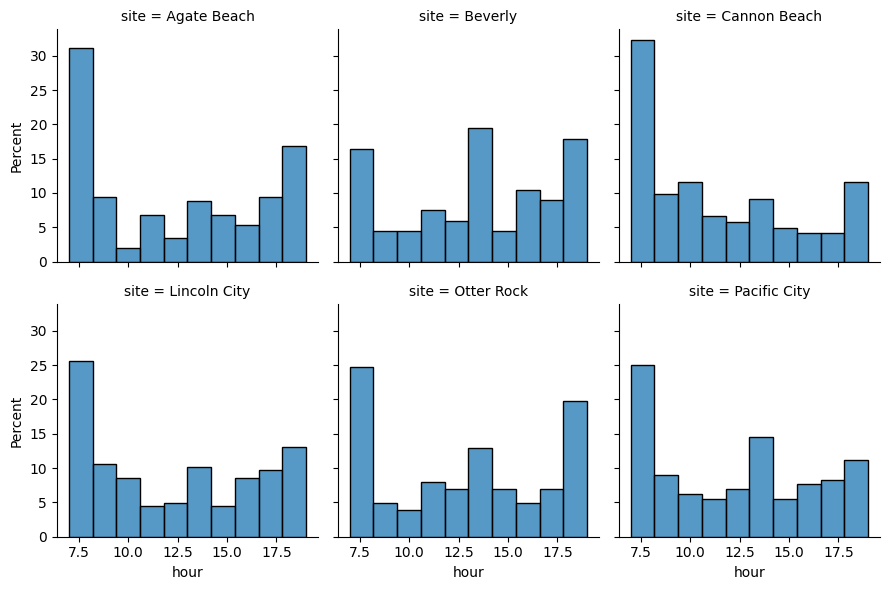

In [18]:
g = sns.FacetGrid(data=fog_results.loc[fog_results['Label_train'] == 1]
              ,col='site', col_wrap=3, sharey=True)
g.map(sns.histplot, 'hour', stat="percent", bins = 10)

In [20]:
##aggregate by day, have number of foggy hours per day
day_sum = fog_results.groupby(['site','date', 'year', 'month'])['rf_pred'].sum().reset_index()
day_sum['fog_day']=0
day_sum.loc[day_sum['rf_pred']>0, 'fog_day'] = 1

/opt/anaconda3/envs/stenv/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/stenv/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/stenv/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/stenv/lib/python3.9/

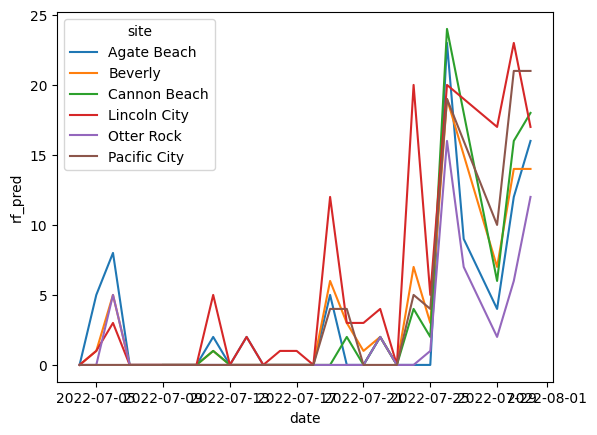

In [21]:
sp = sns.lineplot(day_sum.loc[(day_sum['year']==2022)
                    &(day_sum['month']==7)
                        ], x = 'date', y = 'rf_pred',hue = 'site')

# plt.setp(sp.get_xticklabels(), rotation=45, ha='right') # Set the rotation for the tick labels


In [8]:
dataset=fog_results
index = 'time_pst'
columns = 'site'
values = 'rf_pred'
compare_cooccure = dataset.pivot(index=index, columns=columns, values=values).reset_index()

# Initialize the co-occurrence matrix with zeros
matrix_df = pd.DataFrame(0, index=dataset[columns].unique(), columns=dataset[columns].unique())

# Generate all unique pairs of columns and calculate the percentage of time both equal 1
for pair in itertools.permutations(matrix_df.index, 2):
    # if pair[0] != pair[1]:  # Exclude self-comparison to avoid a symmetrical heatmap
        matrix_df.at[pair[0], pair[1]]  = (compare_cooccure.loc[compare_cooccure[pair[0]] == 1, list(pair)].prod(axis=1) == 1).mean() 
matrix_df.fillna(1, inplace=True)
matrix_df

/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_1171/3977238812.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8993377483443709' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix_df.at[pair[0], pair[1]]  = (compare_cooccure.loc[compare_cooccure[pair[0]] == 1, list(pair)].prod(axis=1) == 1).mean()
/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_1171/3977238812.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.33245033112582784' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix_df.at[pair[0], pair[1]]  = (compare_cooccure.loc[compare_cooccure[pair[0]] == 1, list(pair)].prod(axis=1) == 1).mean()
/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_1171/3977238812.py:13: FutureWarning: Setting an

,Agate Beach,Beverly,Cannon Beach,Lincoln City,Otter Rock,Pacific City
Agate Beach,0.000000,0.899338,0.332450,0.598675,0.529801,0.350993
Beverly,0.738462,0.000000,0.446154,0.623077,0.580769,0.519231
Cannon Beach,0.546798,0.834975,0.000000,0.615764,0.389163,0.428571
Lincoln City,0.529095,0.892241,0.289871,0.000000,0.380388,0.382543
Otter Rock,0.668151,0.982183,0.267261,0.563474,0.000000,0.409800
Pacific City,0.615063,0.905858,0.376569,0.753138,0.512552,0.000000


In [4]:
### % of times that sites experienced fog at the same time
compare_cooccure = fog_results.pivot(index = 'time_pst', columns = 'site', values = 'rf_pred').reset_index()


In [23]:
compare_cooccure.columns

Index(['time_pst', 'Agate Beach', 'Beverly', 'Cannon Beach', 'Lincoln City',
       'Otter Rock', 'Pacific City'],
      dtype='object', name='site')

In [24]:
compare_cooccure.describe() 
compare_cooccure = fog_results.pivot(index = 'time_pst', columns = 'site', values = 'rf_pred').reset_index()
 # Calculate the percentage of time each pair of variables both equal 1
matrix_df = pd.DataFrame(index=fog_results.site.unique()
                         , columns=fog_results.site.unique())

# Generate all unique pairs of columns
for pair in itertools.permutations(compare_cooccure[['Agate Beach', 'Beverly'
           , 'Cannon Beach', 'Lincoln City',
       'Otter Rock', 'Pacific City']], 2):
    # Calculate the mean where both columns in the pair are 1
    matrix_df.at[pair[0], pair[1]]  = (compare_cooccure.loc[compare_cooccure[pair[0]] == 1, list(pair)].prod(axis=1) == 1).mean() 

matrix_df



,Agate Beach,Beverly,Cannon Beach,Lincoln City,Otter Rock,Pacific City
Agate Beach,NaN,0.899338,0.33245,0.598675,0.529801,0.350993
Beverly,0.738462,NaN,0.446154,0.623077,0.580769,0.519231
Cannon Beach,0.546798,0.834975,NaN,0.615764,0.389163,0.428571
Lincoln City,0.529095,0.892241,0.289871,NaN,0.380388,0.382543
Otter Rock,0.668151,0.982183,0.267261,0.563474,NaN,0.4098
Pacific City,0.615063,0.905858,0.376569,0.753138,0.512552,NaN


/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_6593/2256116020.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matrix_df.fillna(1, inplace=True)


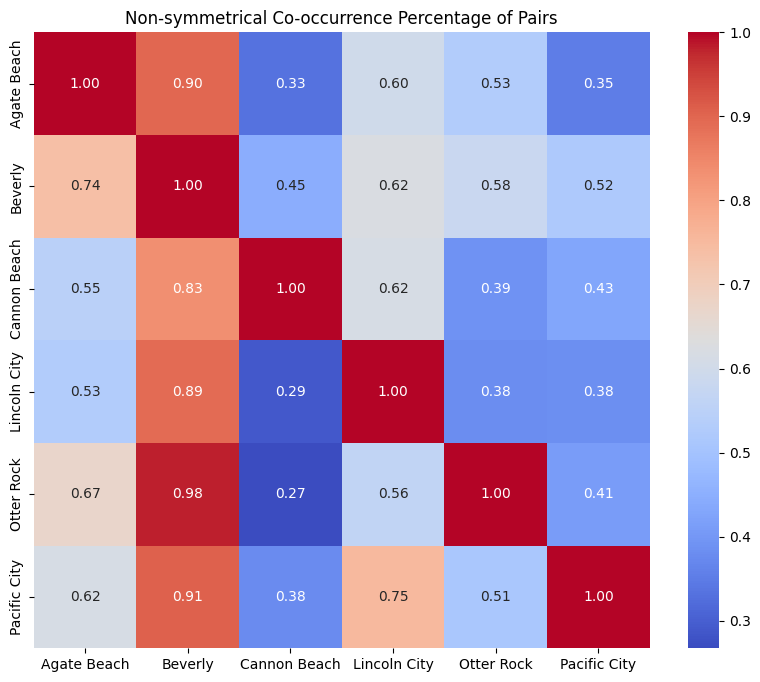

In [25]:
matrix_df.fillna(1, inplace=True)

# Now, use seaborn's heatmap function to plot this matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_df, annot=True, fmt=".2f", cmap="coolwarm", square=True, mask=matrix_df == 0)  # Annotate each cell with the percentage values
plt.title("Non-symmetrical Co-occurrence Percentage of Pairs")
plt.show()


In [125]:
compare_day.columns

Index(['Agate Beach', 'Beverly', 'Cannon Beach', 'Lincoln City', 'Otter Rock',
       'Pacific City'],
      dtype='object', name='site')

/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_6593/660713056.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  day_matrix_df.fillna(1, inplace=True)


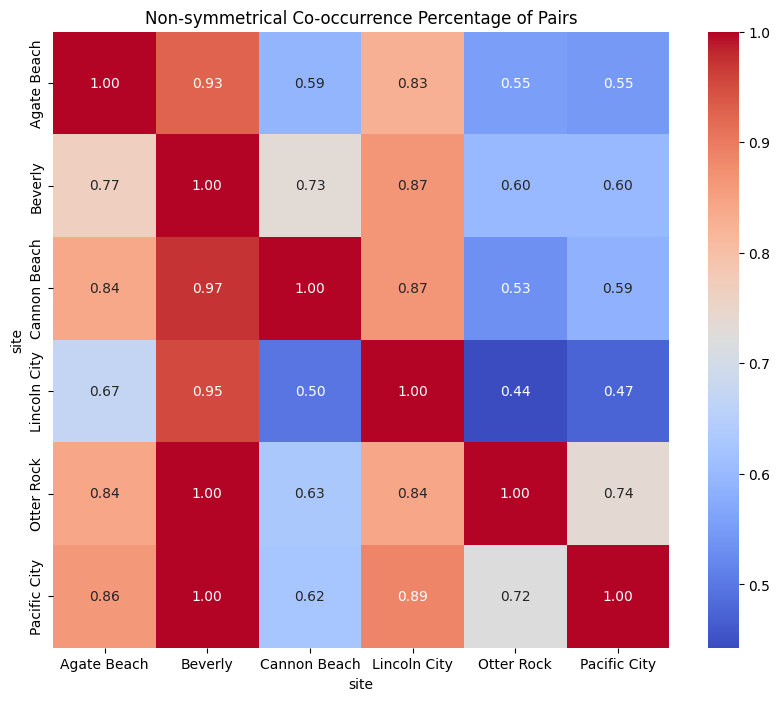

In [26]:

compare_day = day_sum.pivot(index = 'date'
                                 , columns = 'site'
                                 , values = 'fog_day')
 # Calculate the percentage of time each pair of variables both equal 1
day_matrix_df = pd.DataFrame(index=compare_day.columns
                         , columns=compare_day.columns)

# Generate all unique pairs of columns
for pair in itertools.permutations(compare_day[['Agate Beach', 'Beverly'
           , 'Cannon Beach', 'Lincoln City',
       'Otter Rock', 'Pacific City']], 2):
    # Calculate the mean where both columns in the pair are 1
    day_matrix_df.at[pair[0], pair[1]]  = (compare_day.loc[compare_day[pair[0]] == 1, list(pair)].prod(axis=1) == 1).mean() 

# day_matrix_df
day_matrix_df.fillna(1, inplace=True)

# Now, use seaborn's heatmap function to plot this matrix
plt.figure(figsize=(10, 8))
sns.heatmap(day_matrix_df, annot=True, fmt=".2f", cmap="coolwarm", square=True, mask=matrix_df == 0)  # Annotate each cell with the percentage values
plt.title("Non-symmetrical Co-occurrence Percentage of Pairs")
plt.show()


In [35]:
day_sum

,site,date,year,month,rf_pred,fog_day
0,Agate Beach,2022-07-04,2022,7,0,0
1,Agate Beach,2022-07-05,2022,7,5,1
2,Agate Beach,2022-07-06,2022,7,8,1
3,Agate Beach,2022-07-07,2022,7,0,0
4,Agate Beach,2022-07-08,2022,7,0,0
...,...,...,...,...,...,...
1191,Pacific City,2023-09-26,2023,9,0,0
1192,Pacific City,2023-09-27,2023,9,0,0
1193,Pacific City,2023-09-28,2023,9,0,0
1194,Pacific City,2023-09-29,2023,9,0,0


In [ ]:
###lag statistical measures



Index(['station', 'valid', 'lon', 'lat', 'elevation', 'tmpf', 'dwpf', 'relh',
       'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby', 'gust', 'skyc1',
       'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3', 'skyl4',
       'wxcodes', 'ice_accretion_1hr', 'ice_accretion_3hr',
       'ice_accretion_6hr', 'peak_wind_gust', 'peak_wind_drct',
       'peak_wind_time', 'feel', 'metar', 'snowdepth'],
      dtype='object')

In [43]:
filtered_data = fog_results.loc[(fog_results['year']==2023) & (fog_results['month']==5)
                        &(fog_results['site']=='Agate Beach')]

filtered_data.loc[filtered_data['rf_pred'] == 0, 'rf_pred_plot'] = np.nan
filtered_data.loc[filtered_data['rf_pred'] == 1, 'rf_pred_plot'] = 1.025
filtered_data.loc[filtered_data['cnn_pred'] == 0, 'cnn_pred_plot'] = np.nan
filtered_data.loc[filtered_data['cnn_pred'] == 1, 'cnn_pred_plot'] = 1.05
filtered_data.loc[filtered_data['logit_pred'] == 0, 'logit_pred_plot'] = np.nan
filtered_data.loc[filtered_data['logit_pred'] == 1, 'logit_pred_plot'] = 1.075
filtered_data.loc[filtered_data['Label_train'] == 0, 'Label_train'] = np.nan


/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_6593/3628473714.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_6593/3628473714.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_6593/3628473714.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_6593/3658573696.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



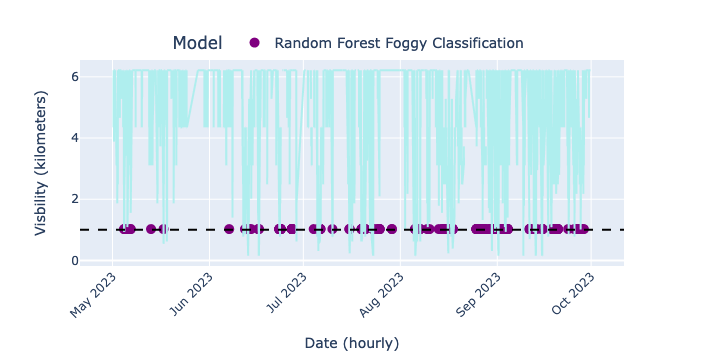

In [38]:
## reproduce visibility / relh
filtered_data['vsby'] = filtered_data['vsby']/1.60934
import plotly.express as px

# Create the main line plot for Relative Humidity
fig2 = px.line(
    filtered_data,
    x='time_pst',
    y='vsby',
    labels={'vsby': 'ASOS Visbility'},
    color_discrete_sequence=['paleturquoise']
)
fig2.add_scatter(
x=filtered_data['time_pst'],
y=filtered_data['rf_pred_plot'],
mode='markers',
name='Random Forest Foggy Classification',
marker=dict(color='purple', size=10)
)
fig2.add_hline(y=1, line=dict(color='black', dash='dash'))

fig2.update_layout(
    legend=dict(
        y=1,  # y=1 places the legend at the top
        x=0.5,  # x=0.5 centers the legend
        xanchor='center',  # 'center' means the center of the legend is at x position
        yanchor='bottom',  # 'bottom' means the bottom of the legend is at the y position
        orientation='h'  # Horizontal orientation
    ),
    # ... other layout properties
)
# Update layout of the fig2ure
fig2.update_layout(
    xaxis_title='Date (hourly)',
    yaxis_title='Visbility (kilometers)',
    # yaxis_tickformat='.0%',  # Add this line to format the y-axis ticks as percentages
    xaxis_tickangle=-45,
    legend_title_text='Model',
    legend_font_size=14,
    height=500,
)


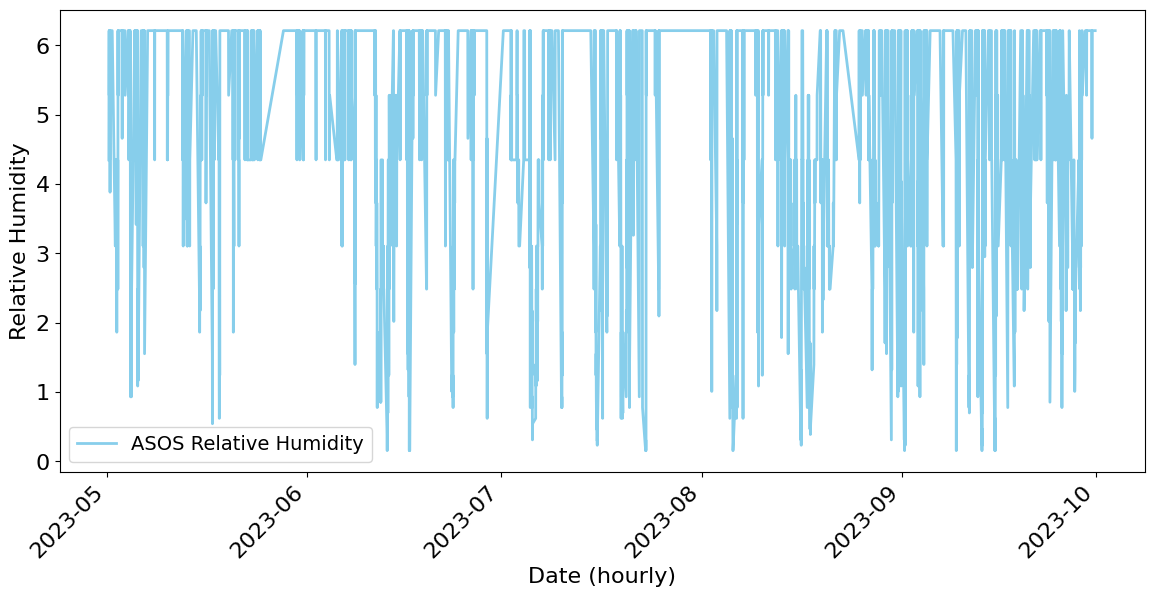

In [36]:
plt.figure(figsize=(14, 6)) 
ax = sns.lineplot(x = 'time_pst', y = 'vsby', data = filtered_data
                 , label='ASOS Relative Humidity', color='skyblue', lw = 2)
# tt = sns.scatterplot(x = 'valid', y = 'rf_pred', data = plt_data
#                    , label='Random Forest Foggy Classification', color='purple', s = 125 )
# t1 = sns.scatterplot(x = 'valid', y = 'logit_pred', data = plt_data
#                    , label='Logistic Regression Foggy Classification', color='mediumvioletred', s = 125 )
# t2 = sns.scatterplot(x = 'valid', y = 'Label_train', data = plt_data
#                    , label='Labeled Foggy', color='darkgreen' , marker='^', s = 125)
# tt2 = sns.scatterplot(x = 'valid', y = 'logit_pred', data = plt_data)
plt.xlabel('Date (hourly)', fontsize = 16)
# plt.ylim(0, 2500)
plt.ylabel('Relative Humidity', fontsize = 16)
# plt.tight_layout()  # Ensure labels are not cut off
plt.tick_params(axis='both', labelsize=16)
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment
plt.legend(fontsize=14)

/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_6593/300077492.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



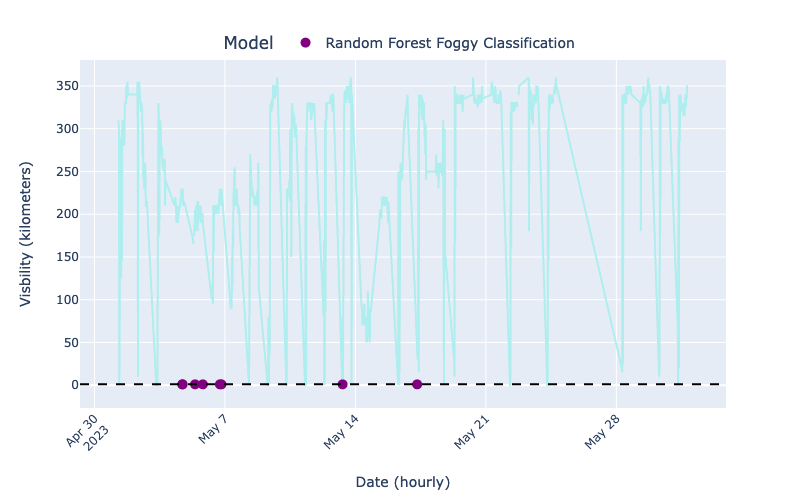

In [44]:
## plot temperature
## reproduce visibility / relh
filtered_data['sknt'] = filtered_data['sknt'] * 0.51444
import plotly.express as px

# Create the main line plot for Relative Humidity
fig2 = px.line(
    filtered_data,
    x='time_pst',
    y='drct',
    labels={'drct': 'ASOS Temp (C)'},
    color_discrete_sequence=['paleturquoise']
)
fig2.add_scatter(
x=filtered_data['time_pst'],
y=filtered_data['rf_pred_plot'],
mode='markers',
name='Random Forest Foggy Classification',
marker=dict(color='purple', size=10)
)
fig2.add_hline(y=1, line=dict(color='black', dash='dash'))

fig2.update_layout(
    legend=dict(
        y=1,  # y=1 places the legend at the top
        x=0.5,  # x=0.5 centers the legend
        xanchor='center',  # 'center' means the center of the legend is at x position
        yanchor='bottom',  # 'bottom' means the bottom of the legend is at the y position
        orientation='h'  # Horizontal orientation
    ),
    # ... other layout properties
)
# Update layout of the fig2ure
fig2.update_layout(
    xaxis_title='Date (hourly)',
    yaxis_title='Visbility (kilometers)',
    # yaxis_tickformat='.0%',  # Add this line to format the y-axis ticks as percentages
    xaxis_tickangle=-45,
    legend_title_text='Model',
    legend_font_size=14,
    height=500,
)


In [ ]:
## plot average windspeed

In [ ]:
## plot average wind direction by ASOS site